In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage
import os
import sys
import csv
from sklearn.metrics import mean_squared_error
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means
# from skimage.measure import compare_ssim
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
# from skimage.measure import compare_ssim
# from skimage.measure import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as compare_mse
from scipy import ndimage, misc
from sklearn.utils import shuffle
import math
from tensorflow.keras.models import model_from_json, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import re
from tensorflow.keras import regularizers
#from keras.utils import plot_model
#from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers.core import Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import mean_squared_error
import scipy.io as sio
import pickle
from random import randint

from PIL import Image

from IPython.display import clear_output

In [2]:
print(tf.__version__)

2.8.0


In [3]:
#Convert rgb to gray
def rgb2gray(rgb):

    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

#Read images from folder of given path
def read_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path,filename),0)
        if img is not None:
            images.append(img)
    return np.array(images)

def resize_images(images,size):
    resized_images = []
    
    for img in images:
        im2 = cv2.resize(img,size,interpolation = cv2.INTER_CUBIC)
        resized_images.append(im2)
    
    resized_images = np.array(resized_images)
    resized_images = np.reshape(resized_images,(resized_images.shape[0],resized_images.shape[1],resized_images.shape[2],1))
    
    return resized_images

#Shuffle the noisy image ground truth pair to randomize the noise distribution in the dataset
def expand_pair(noisy_set):   
    ground_truth=[]
    noisy_images = []
    for i in range(noisy_set.shape[0]):
        ground_truth.append(noisy_set[i][0].reshape((noisy_set[i][0].shape[0],noisy_set[i][0].shape[1],1)))
        #print( str(noisy_set[i][0].shape[0]) +" "+ str(noisy_set[i][0].shape[1]))
        noisy_images.append(noisy_set[i][1].reshape((noisy_set[i][1].shape[0],noisy_set[i][1].shape[1],1)))
    return ground_truth, noisy_images

In [4]:
#Function to get saved keras model
def read_model_json(jsonfilePath,h5filePath):
    try:
        json_file = open(jsonfilePath, 'r')
        print(json_file)
        loaded_model_json = json_file.read()
        json_file.close()
        print("hello")
        loaded_model = model_from_json(loaded_model_json)
         
        # load weights into new model
        loaded_model.load_weights(h5filePath)

        return loaded_model
    except:
        return None

    """Function to mimic the 'fspecial' gaussian MATLAB function
    """
    x_data, y_data = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]

    x_data = np.expand_dims(x_data, axis=-1)
    x_data = np.expand_dims(x_data, axis=-1)

    y_data = np.expand_dims(y_data, axis=-1)
    y_data = np.expand_dims(y_data, axis=-1)

    x = tf.constant(x_data, dtype=tf.float32)
    y = tf.constant(y_data, dtype=tf.float32)

    g = tf.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g / tf.reduce_sum(g)# def _tf_fspecial_gauss(size, sigma):


def tf_ssim(img1, img2, cs_map=False, mean_metric=True, size=11, sigma=1.5):
    window = _tf_fspecial_gauss(size, sigma) # window shape [size, size]
    K1 = 0.01
    K2 = 0.03
    L = 1  # depth of image (255 in case the image has a differnt scale)
    C1 = (K1*L)**2
    C2 = (K2*L)**2
    mu1 = tf.nn.conv2d(img1, window, strides=[1,1,1,1], padding='VALID')
    mu2 = tf.nn.conv2d(img2, window, strides=[1,1,1,1],padding='VALID')
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    sigma1_sq = tf.nn.conv2d(img1*img1, window, strides=[1,1,1,1],padding='VALID') - mu1_sq
    sigma2_sq = tf.nn.conv2d(img2*img2, window, strides=[1,1,1,1],padding='VALID') - mu2_sq
    sigma12 = tf.nn.conv2d(img1*img2, window, strides=[1,1,1,1],padding='VALID') - mu1_mu2
    if cs_map:
        value = (((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2)),
                (2.0*sigma12 + C2)/(sigma1_sq + sigma2_sq + C2))
    else:
        value = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*
                    (sigma1_sq + sigma2_sq + C2))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def tf_ms_ssim(img1, img2, mean_metric=True, level=5):
    weight = tf.constant([0.0448, 0.2856, 0.3001, 0.2363, 0.1333], dtype=tf.float32)
    mssim = []
    mcs = []
    for l in range(level):
        ssim_map, cs_map = tf_ssim(img1, img2, cs_map=True, mean_metric=False)
        mssim.append(tf.reduce_mean(ssim_map))
        mcs.append(tf.reduce_mean(cs_map))
        filtered_im1 = tf.nn.avg_pool(img1, [1,2,2,1], [1,2,2,1], padding='SAME')
        filtered_im2 = tf.nn.avg_pool(img2, [1,2,2,1], [1,2,2,1], padding='SAME')
        img1 = filtered_im1
        img2 = filtered_im2

    # list to tensor of dim D+1
    mssim = tf.stack(mssim, axis=0)
    mcs = tf.stack(mcs, axis=0)

    value = (tf.reduce_prod(mcs[0:level-1]**weight[0:level-1])*
                            (mssim[level-1]**weight[level-1]))

    if mean_metric:
        value = tf.reduce_mean(value)
    return value

def dssim_objective(y_pred,y_true):
    ssim = tf_ssim(y_pred,y_true)
    return (1 - ssim)/2.

In [5]:
def get_gated_connections(gatePercentageFactor,inputLayer):
    fractionG = Lambda(lambda x, factor : factor * x, arguments = {'factor': gatePercentageFactor})(inputLayer)
    complement = Lambda(lambda x: x[0] - x[1])([inputLayer,fractionG])
    
    return fractionG,complement

#x is conv layer
#y is de-conv layer
#gf is gating factor
#fg is fractional input from gate
#c is complement ie remaining fraction from the gate
#jt joining tensor of convolution layer and previous de-conv layer 

def get_cnn_dsc_architecture(model_path=None):
    
    if(model_path is None):
        sym_autoencoder = None
    else:
        sym_autoencoder = read_model_json(model_path[0],model_path[1])
    conv_filter = (3 , 3)
    if(sym_autoencoder is None):
        input_img = Input(shape=(None,None,1), name = "Image_input")  # adapt this if using `channels_first` image data format
        x1 = Conv2D(64, conv_filter, activation='relu', padding='same')(input_img)
        fg1,c1 = get_gated_connections(0.1,x1)
        x = MaxPooling2D((2, 2), padding='same')(fg1)
        x2 = Conv2D(64, conv_filter, activation='relu', padding='same')(x) 
        fg2,c2 = get_gated_connections(0.2,x2)

        x = MaxPooling2D((2, 2), padding='same')(fg2)
        x3 = Conv2D(128, conv_filter, activation='relu', padding='same')(x) 
        fg3,c3 = get_gated_connections(0.3,x3)

        x = MaxPooling2D((2, 2), padding='same')(x3)
        x4 = Conv2D(256, conv_filter, activation='relu', padding='same')(x) 
        fg4,c4 = get_gated_connections(0.4,x4)

        x = MaxPooling2D((2, 2), padding='same')(x4)
        x5 = Conv2D(512, conv_filter, activation='relu', padding='same')(x) 

        x = UpSampling2D((2, 2))(x5)
        y1 = Conv2DTranspose(256, conv_filter, activation='relu', padding='same')(x) 
        jt4 = Add()([y1,c4])
        x = UpSampling2D((2, 2))(jt4)

        y2 = Conv2DTranspose(128, conv_filter, activation='relu', padding='same')(x) 
        jt3 = Add()([y2,c3])
        x = UpSampling2D((2, 2))(jt3)

        y3 = Conv2DTranspose(64, conv_filter, activation='relu', padding='same')(x) 
        jt2 = Add()([y3,c2])
        x = UpSampling2D((2, 2))(jt2)

        jt1 = Add()([x,c1])
        y4 = Conv2DTranspose(64, conv_filter, activation='relu', padding='same')(jt1)
        y5 = Conv2DTranspose(1, conv_filter, activation='relu', padding='same')(y4) 

        layers = y5

        sym_autoencoder = Model(input_img,layers)
        sym_autoencoder.compile(optimizer='adam', loss = dssim_objective, metrics = ['accuracy',dssim_objective])
        print("Model created")
    else:
        print("Saved model loaded")
    #print(sym_autoencoder.summary())
    return sym_autoencoder

In [6]:
sym_autoencoder = get_cnn_dsc_architecture()

Model created


In [20]:
# sourceLocation = './datasets/segmentation/Resized_train/*'
#sourceLocation = './experiments/diagrams/1/*'
targetLocation = r'D:/'
# targetLocation = './datasets/segmentation/Train_images_original_denoised/'
#targetLocation = './experiments/diagrams/1/'

sym_autoencoder = get_cnn_dsc_architecture()
#sym_autoencoder.load_weights("./models/patchwise_fisk.hdf5")
sym_autoencoder.load_weights("patchwise_synthetic.hdf5")
# sym_autoencoder.load_weights("./models/patchwise_gamma_beta_gen_epoch_200.hdf5")
#sym_autoencoder.load_weights("./models/patchwise_synthetic.hdf5")
#sym_autoencoder.load_weights("./models/patchwise_logistic.hdf5")


#for i, filename in enumerate(glob(sourceLocation)):
    #params = filename.split('/')[-1].split('.')[0]
    
    #print(filename)
#filename=r"F:\anoop b n\OCT\OCT\OCT_denoising\patchwise\paper\abnbeta1.png"
#filename=r"F:\anoop b n\OCT\OCT\OCT_denoising\patchwise\datasets\gt+im\26_2\IM_rename\001.tif"
filename=r"D:\Main_project\Project\Today\Bscan_3.jpg"
#filename=r"F:\anoop b n\OCT\OCT\OCT_denoising\patchwise\abn_1\abn_beta\abnbeta12.png"
x_test_noisy_r1 = cv2.imread(filename,0).astype(np.float32) / 255.0
print(x_test_noisy_r1.shape)
x_test_noisy_r = cv2.imread(filename,0).astype(np.float32) / 255.0
print(x_test_noisy_r.shape)
# dims = np.shape(x_test_noisy_r)
# marginalDims = (16-(dims[0]%16), 16-(dims[1]%16))
    
# x_test_noisy_r = np.pad(x_test_noisy_r , [(0,marginalDims[0]), (0,marginalDims[1])], mode='constant')   

# x_test_noisy_r = np.reshape(x_test_noisy_r,(x_test_noisy_r.shape[0],x_test_noisy_r.shape[1],1))
    
x_out_r = sym_autoencoder.predict_on_batch(np.array([x_test_noisy_r]))
x_out_r= x_out_r*255

#     cv2.imwrite(targetLocation + 'denoise_' + str(params) + '.png',x_out_r[0][:dims[0]][:dims[1]]*255.)
#cv2.imwrite(targetLocation + 'denoiseDukew_' + str(params) + '.png',x_out_r[0,:dims[0],:dims[1]]*255.)


Model created
(1024, 512)


In [21]:
print((x_out_r*255).max())

224.9701


In [22]:
x_out_r.shape

(1, 1024, 512, 1)

In [23]:
#x_out_r1=np.reshape(x_out_r,[1040,528])
x_out_r1=np.reshape(x_out_r,[1024, 512])
# x_out_r1=x_out_r1[0:450,0:900]

(-0.5, 511.5, 1023.5, -0.5)

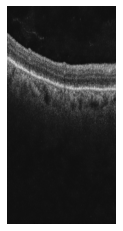

In [24]:
from skimage import io
import matplotlib.pyplot as plt
# read the image stack
#img = io.imread(path)
# show the image
plt.imshow(x_out_r1*255,cmap='gray')
plt.axis('off')
# save the image
#plt.savefig('output.tif', transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)

In [ ]:
cv2.imwrite(targetLocation+"/"+ "image.png", x_out_r1*255)    